In [1]:
import os
import sys
import ast
from staticfg.builder import CFGBuilder
import astpretty
import yaml

import matplotlib as mpl
import  matplotlib.pyplot as plt
import scienceplots
import numpy as np
import networkx as nx

from hardwareModel import HardwareModel
import hardwareModel

plt.style.use(['science', 'nature']) #, 'presentation'])

In [2]:
filepath = "benchmarks/models/matmult_from_file.py"
src_file =  open(filepath, 'r')
src = src_file.read() 
tree = ast.parse(src, mode='exec')
cfg = CFGBuilder().build_from_src('main.c', src)

In [3]:
cfg.build_visual('test_cfg', format='png')

In [ ]:
astpretty.pprint(tree, show_offsets=False, indent='  ',)

## test AST node transformer

In [7]:
code = "\
def tmp(x):\n \
    x = 3\n \
    return x\n \
\n\
def nested_func(interesting_func, y):\n \
    z = intereseting_func(y)\n \
    return z\n \
\n\
def read_weights_from_file(a):\n \
    v = 0\n \
    return a * 276345\n \
\n\
a = 20\n\
\n\
w, v = read_weights_from_file()\n \
"
# 

tree = ast.parse(code)

astpretty.pprint(tree, show_offsets=False, indent='  ',)

Module(
  body=[
    FunctionDef(
      name='tmp',
      args=arguments(
        posonlyargs=[],
        args=[arg(arg='x', annotation=None, type_comment=None)],
        vararg=None,
        kwonlyargs=[],
        kw_defaults=[],
        kwarg=None,
        defaults=[],
      ),
      body=[
        Assign(
          targets=[Name(id='x', ctx=Store())],
          value=Constant(value=3, kind=None),
          type_comment=None,
        ),
        Return(
          value=Name(id='x', ctx=Load()),
        ),
      ],
      decorator_list=[],
      returns=None,
      type_comment=None,
    ),
    FunctionDef(
      name='nested_func',
      args=arguments(
        posonlyargs=[],
        args=[
          arg(arg='interesting_func', annotation=None, type_comment=None),
          arg(arg='y', annotation=None, type_comment=None),
        ],
        vararg=None,
        kwonlyargs=[],
        kw_defaults=[],
        kwarg=None,
        defaults=[],
      ),
      body=[
        Assign(
     

In [13]:
class testTransformer(ast.NodeTransformer):
    def visit_Assign(self, node):
        if type(node.value) == ast.Call and node.value.func == ast.Name:
              print(node.value.func.id)
              if ("file" in node.value.func.id and "read" in node.value.func.id):
                    print("Found file read")
                    # change the node.targets[0] name to include _NVM.
                    if type(node.targets[0]) == ast.Name:
                        node.targets[0].id = node.targets[0].id + "_NVM"
                    elif type(node.targets[0]) == ast.Tuple:
                        for target in node.targets[0].elts:
                            target.id = target.id + "_NVM"
            #   print(node.value.args[0].id)
        astpretty.pprint(node, show_offsets=False, indent='  ',)
        return node
        


In [8]:
a = []
if a:
    print("a is not empty")
else:
    print("a is empty")

a is empty


In [14]:
testTransformer().visit(tree)

Assign(
  targets=[Name(id='x', ctx=Store())],
  value=Constant(value=3, kind=None),
  type_comment=None,
)
intereseting_func
Assign(
  targets=[Name(id='z', ctx=Store())],
  value=Call(
    func=Name(id='intereseting_func', ctx=Load()),
    args=[Name(id='y', ctx=Load())],
    keywords=[],
  ),
  type_comment=None,
)
Assign(
  targets=[Name(id='v', ctx=Store())],
  value=Constant(value=0, kind=None),
  type_comment=None,
)
read_weights_from_file
Found file read
Assign(
  targets=[
    Tuple(
      elts=[
        Name(id='w_NVM', ctx=Store()),
        Name(id='v_NVM', ctx=Store()),
      ],
      ctx=Store(),
    ),
  ],
  value=Call(
    func=Name(id='read_weights_from_file', ctx=Load()),
    args=[],
    keywords=[],
  ),
  type_comment=None,
)


## test object sizes

In [7]:
# from matmult.py
a = [[1, 2, 3], [1, 2, 3], [1, 2, 3]]
b = [[1, 2, 3], [1, 2, 3], [1, 2, 3]]
c = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
d = [9, 9, 9]

i, j = int(0), float(0)

print(f"sizes: i(int): {sys.getsizeof(i)}, j(float): {sys.getsizeof(j)} a: {sys.getsizeof(a)}, a[0][0]: {sys.getsizeof(a[0][0])}, b: {sys.getsizeof(b)}, b[0][0]: {sys.getsizeof(b[0][0])}, c: {sys.getsizeof(c)}, c[0][0]: {sys.getsizeof(c[0][0])}, d: {sys.getsizeof(d)}")
print(f"types: i(int): {type(i)}, j(float): {type(j)} a: {type(a)}, a[0][0]: {type(a[0][0])}, b: {type(b)}, b[0][0]: {type(b[0][0])}, c: {type(c)}, c[0][0]: {type(c[0][0])}, d: {type(d)}")
print(f"lens: a: {len(a)}, a[0]: {len(a[0])}, b: {len(b)}, b[0]: {len(b[0])}, c: {len(c)}, c[0]: {len(c[0])}, d: {len(d)}")

sizes: i(int): 28, j(float): 24 a: 80, a[0][0]: 28, b: 80, b[0][0]: 28, c: 80, c[0][0]: 28, d: 88
types: i(int): <class 'int'>, j(float): <class 'float'> a: <class 'list'>, a[0][0]: <class 'int'>, b: <class 'list'>, b[0][0]: <class 'int'>, c: <class 'list'>, c[0][0]: <class 'int'>, d: <class 'list'>
lens: a: 3, a[0]: 3, b: 3, b[0]: 3, c: 3, c[0]: 3, d: 3


## Test yaml dump tech config

In [2]:
latency = {
    7: {
	   "And": 1.75,
	   "Or": 1.789,
	   "Add": 16,
	   "Sub": 16.175,
	   "Mult": 56.24,
	   "FloorDiv": 43.5,
	   "Mod": 1.935,
	   "LShift": 0.027,
	   "RShift": 0.027,
	   "BitOr": 0.256,
	   "BitXor": 0.236,
	   "BitAnd": 0.24,
	   "Eq": 1.76,
	   "NotEq": 1.935,
	   "Lt": 1.935,
	   "LtE": 1.935,
	   "Gt": 2.615,
	   "GtE": 2.64,
	   "USub": 16.175,
	   "UAdd": 16,
	   "IsNot": 0.175,
	   "Not": 0.175,
	   "Invert": 0.175,
	   "Regs": 2
    },
    5: {
	   "And": 1.545,
	   "Or": 1.58,
	   "Add": 14.155,
	   "Sub": 14.31,
	   "Mult": 49.77,
	   "FloorDiv": 38.56,
	   "Mod": 1.71,
	   "LShift": 0.024,
	   "RShift": 0.024,
	   "BitOr": 0.225,
	   "BitXor": 0.208,
	   "BitAnd": 0.213,
	   "Eq": 1.555,
	   "NotEq": 1.71,
	   "Lt": 1.71,
	   "LtE": 1.71,
	   "Gt": 2.315,
	   "GtE": 2.335,
	   "USub": 14.31,
	   "UAdd": 14.155,
	   "IsNot": 0.155,
	   "Not": 0.155,
	   "Invert": 0.155,
	   "Regs": 2
    },
    3: {
	   "And": 1.395,
	   "Or": 1.425,
	   "Add": 12.755,
	   "Sub": 12.895,
	   "Mult": 44.835,
	   "FloorDiv": 34.741,
	   "Mod": 1.54,
	   "LShift": 0.214,
	   "RShift": 0.214,
	   "BitOr": 0.2,
	   "BitXor": 0.188,
	   "BitAnd": 0.192,
	   "Eq": 1.4,
	   "NotEq": 1.54,
	   "Lt": 1.54,
	   "LtE": 1.54,
	   "Gt": 2.085,
	   "GtE": 2.105,
	   "USub": 12.895,
	   "UAdd": 12.755,
	   "IsNot": 0.14,
	   "Not": 0.14,
	   "Invert": 0.14,
	   "Regs": 2
    }
}

# in nW
dynamic_power = {
    7: { 
	   "And": 81.809,
	   "Or": 77.035,
	   "Add": 49.728,
	   "Sub": 56.896,
	   "Mult": 9227.952,
	   "FloorDiv": 26128.576,
	   "Mod": 116.025,
	   "LShift": 78.144,
	   "RShift": 78.144,
	   "BitOr": 22.72,
	   "BitXor": 25.6,
	   "BitAnd": 24.128,
	   "Eq": 108.857,
	   "NotEq": 176.977,
	   "Lt": 170.539,
	   "LtE": 160.534,
	   "Gt": 162.316,
	   "GtE": 143.232,
	   "USub": 56.896,
	   "UAdd": 49.728,
	   "IsNot": 7.168,
	   "Not": 7.168,
	   "Invert": 7.168,
	   "Regs": 1
    },
    5: { 
	   "And": 64.62911,
	   "Or": 60.85765,
	   "Add": 39.28512,
	   "Sub": 44.94784,
	   "Mult": 7290.08208,
	   "FloorDiv": 20641.57504,
	   "Mod": 91.65975,
	   "LShift": 61.73376,
	   "RShift": 61.73376,
	   "BitOr": 17.9488,
	   "BitXor": 20.224,
	   "BitAnd": 19.06112,
	   "Eq": 85.99703,
	   "NotEq": 139.81183,
	   "Lt": 134.72581,
	   "LtE": 126.82186,
	   "Gt": 128.22964,
	   "GtE": 113.15328,
	   "USub": 44.94784,
	   "UAdd": 39.28512,
	   "IsNot": 5.66272,
	   "Not": 5.66272,
	   "Invert": 5.66272,
	   "Regs": 1
    },
    3: { 
	   "And": 47.1792503,
	   "Or": 44.4260845,
	   "Add": 28.6781376,
	   "Sub": 32.8119232,
	   "Mult": 5321.759918,
	   "FloorDiv": 15068.34978,
	   "Mod": 66.9116175,
	   "LShift": 45.0656448,
	   "RShift": 45.0656448,
	   "BitOr": 13.102624,
	   "BitXor": 14.76352,
	   "BitAnd": 13.9146176,
	   "Eq": 62.7778319,
	   "NotEq": 102.0626359,
	   "Lt": 98.3498413,
	   "LtE": 92.5799578,
	   "Gt": 93.6076372,
	   "GtE": 82.6018944,
	   "USub": 32.8119232,
	   "UAdd": 28.6781376,
	   "IsNot": 4.1337856,
	   "Not": 4.1337856,
	   "Invert": 4.1337856,
	   "Regs": 1
    }
}

leakage_power = {
	7: { 
	   "And": 4340,
	   "Or": 4340,
	   "Add": 2986.666667,
	   "Sub": 3413.333333,
	   "Mult": 538320,
	   "FloorDiv": 1422080,
	   "Mod": 3860,
	   "LShift": 4266.666667,
	   "RShift": 4266.666667,
	   "BitOr": 1280,
	   "BitXor": 1706.666667,
	   "BitAnd": 1280,
	   "Eq": 3433.333333,
	   "NotEq": 6046.666667,
	   "Lt": 6046.666667,
	   "LtE": 4600,
	   "Gt": 4600,
	   "GtE": 4693.333333,
	   "USub": 3413.333333,
	   "UAdd": 2986.666667,
	   "IsNot": 426.6666667,
	   "Not": 426.6666667,
	   "Invert": 426.6666667,
	   "Regs": 426.6666667
    },
    5: { 
	   "And": 3428.6,
	   "Or": 3428.6,
	   "Add": 2359.466667,
	   "Sub": 2696.533333,
	   "Mult": 425272.8,
	   "FloorDiv": 1123443.2,
	   "Mod": 3049.4,
	   "LShift": 3370.666667,
	   "RShift": 3370.666667,
	   "BitOr": 1011.2,
	   "BitXor": 1348.266667,
	   "BitAnd": 1011.2,
	   "Eq": 2712.333333,
	   "NotEq": 4776.866667,
	   "Lt": 4776.866667,
	   "LtE": 3634,
	   "Gt": 3634,
	   "GtE": 3707.733333,
	   "USub": 2696.533333,
	   "UAdd": 2359.466667,
	   "IsNot": 337.0666667,
	   "Not": 337.0666667,
	   "Invert": 337.0666667,
	   "Regs": 1
    },
    3: { 
	   "And": 2502.878,
	   "Or": 2502.878,
	   "Add": 1722.410667,
	   "Sub": 1968.469333,
	   "Mult": 310449.144,
	   "FloorDiv": 820113.536,
	   "Mod": 2226.062,
	   "LShift": 2460.586667,
	   "RShift": 2460.586667,
	   "BitOr": 738.176,
	   "BitXor": 984.2346667,
	   "BitAnd": 738.176,
	   "Eq": 1980.003333,
	   "NotEq": 3487.112667,
	   "Lt": 3487.112667,
	   "LtE": 2652.82,
	   "Gt": 2652.82,
	   "GtE": 2706.645333,
	   "USub": 1968.469333,
	   "UAdd": 1722.410667,
	   "IsNot": 246.0586667,
	   "Not": 246.0586667,
	   "Invert": 246.0586667,
	   "Regs": 1
    }
}

# what is this in units of?
area = {
    7: { 
	   "And": 459.3456,
	   "Or": 374.976,
	   "Add": 282.9312,
	   "Sub": 379.6992,
	   "Mult": 51264.3168,
	   "FloorDiv": 155840.7168,
	   "Mod": 400.248,
	   "LShift": 478.3104,
	   "RShift": 478.3104,
	   "BitOr": 110.592,
	   "BitXor": 1147.456,
	   "BitAnd": 135.4752,
	   "Eq": 303.48,
	   "NotEq": 606.8016,
	   "Lt": 923.11872,
	   "LtE": 950.62788,
	   "Gt": 953.48997,
	   "GtE": 831.07392,
	   "USub": 282.9312,
	   "UAdd": 379.6992,
	   "IsNot": 96.768,
	   "Not": 96.768,
	   "Invert": 96.768,
	   "Regs": 1
    },
    5: { 
	   "And": 252.64008,
	   "Or": 206.2368,
	   "Add": 155.61216,
	   "Sub": 208.83456,
	   "Mult": 28195.37424,
	   "FloorDiv": 85712.39424,
	   "Mod": 220.1364,
	   "LShift": 263.07072,
	   "RShift": 263.07072,
	   "BitOr": 60.8256,
	   "BitXor": 81.1008,
	   "BitAnd": 74.51136,
	   "Eq": 166.914,
	   "NotEq": 333.74088,
	   "Lt": 507.715296,
	   "LtE": 522.845334,
	   "Gt": 524.4194835,
	   "GtE": 457.090656,
	   "USub": 155.61216,
	   "UAdd": 208.83456,
	   "IsNot": 53.2224,
	   "Not": 53.2224,
	   "Invert": 53.2224,
	   "Regs": 1
    },
    3: { 
	   "And": 149.0576472,
	   "Or": 121.679712,
	   "Add": 91.8111744,
	   "Sub": 123.2123904,
	   "Mult": 16635.2708,
	   "FloorDiv": 50570.3126,
	   "Mod": 129.880476,
	   "LShift": 155.2117248,
	   "RShift": 155.2117248,
	   "BitOr": 35.887104,
	   "BitXor": 47.849472,
	   "BitAnd": 43.9617024,
	   "Eq": 98.47926,
	   "NotEq": 196.9071192,
	   "Lt": 299.5520246,
	   "LtE": 308.4787471,
	   "Gt": 309.4074953,
	   "GtE": 269.683487,
	   "USub": 91.8111744,
	   "UAdd": 123.2123904,
	   "IsNot": 31.401216,
	   "Not": 31.401216,
	   "Invert": 31.401216,
	   "Regs": 1
    }
}

latency_scale = {
    512: 1,
    1024: 2,
    2048: 3,
    4096: 4,
    8192: 5,
    16384: 6,
    32768: 7,
    65536: 8,
    131072: 9,
    262144: 10,
    524288: 11,
    1048576: 12,
    2097152: 13,
    4194304: 14,
    8388608: 15,
    16777216: 16,
    33554432: 17,
    67108864: 18,
    134217728: 19,
    268435456: 20,
    536870912: 21
}

power_scale = {
    512: 1,
    1024: 2,
    2048: 3,
    4096: 4,
    8192: 5,
    16384: 6,
    32768: 7,
    65536: 8,
    131072: 9,
    262144: 10,
    524288: 11,
    1048576: 12,
    2097152: 13,
    4194304: 14,
    8388608: 15,
    16777216: 16,
    33554432: 17,
    67108864: 18,
    134217728: 19,
    268435456: 20,
    536870912: 21
}

mem_area_7_5 = { # queried by (cache_size, mem_layers, pitch)
	1: {
		1: {
			100: 8.26
		},
		2: {
			100: 21.38,
			10: 8.419, 
			1: 5.373, 
			0.1: 7.34
		}, 
		4: {
			100: 23.02,
			10: 7.499,
			1: 4.025,
			0.1: 2.535
		}
	}, 
	2: {
		1: {
			100: 20.83
		},
		2: {
			100: 27.952,
			10: 13.249,  
			1: 9.822, 
			0.1: 8.061
		}, 
		4: {
			100: 21.33,
			10: 9.657,
			1: 8.05,
			0.1: 7.334
		}
	}, 
	4: {
		1: {
			100: 42.1
		},
		2: {
			100: 43.182,
			10: 26.661, 
			1: 22.363, 
			0.1: 25.8
		}, 
		4: {
			100: 27.83,
			10: 14.089,
			1: 11.77,
			0.1: 25.796
		}
	}, 
	8: {
		1: {
			100: 73.12
		},
		2: {
			100: 65.894,
			10: 43.287, 
			1: 41.146, 
			0.1: 39.63
		}, 
		4: {
			100: 43,
			10: 28.191,
			1: 22.36,
			0.1: 25.796
		}
	}, 
	16: {
		1: {
			100: 137.7
		},
		2: {
			100: 111.754,
			10: 75.741, 
			1: 76.972, 
			0.1: 74.62
		}, 
		4: {
			100: 69.6,
			10: 43.72,
			1: 40.73,
			0.1: 39.219
		}
	}
}

mem_area_3 = {
	1: {
		1: {
			100: 0.34
		},
		2: {
			100: 0.878,
			10: 0.346, 
			1: 0.221, 
			0.1: 0.301
		}, 
		4: {
			100: 0.946,
			10: 0.308,
			1: 0.165,
			0.1: 0.104
		}
	}, 
	2: {
		1: {
			100: 0.856
		},
		2: {
			100: 1.15,
			10: 0.544,  
			1: 0.403, 
			0.1: 0.331
		}, 
		4: {
			100: 0.876,
			10: 0.397,
			1: 0.331,
			0.1: 0.301
		}
	}, 
	4: {
		1: {
			100: 1.73
		},
		2: {
			100: 1.774,
			10: 1.095, 
			1: 0.919, 
			0.1: 1.06
		}, 
		4: {
			100: 1.144,
			10: 0.579,
			1: 0.484,
			0.1: 0.38
		}
	}, 
	8: {
		1: {
			100: 3.004
		},
		2: {
			100: 2.707,
			10: 1.779, 
			1: 1.691, 
			0.1: 1.628
		}, 
		4: {
			100: 1.767,
			10: 1.159,
			1: 0.919,
			0.1: 1.06
		}
	}, 
	16: {
		1: {
			100: 5.658
		},
		2: {
			100: 4.592,
			10: 3.112, 
			1: 3.162, 
			0.1: 3.066
		}, 
		4: {
			100: 2.86,
			10: 1.796,
			1: 1.673,
			0.1: 1.611
		}
	}
}

mem_latency = { 
	1: {
		1: {
			100: 21.325
		},
		2: {
			100: 5.125,
			10: 3.045, 
			1: 14.445, 
			0.1: 2.14
		}, 
		4: {
			100: 4.625,
			10: 2.405,
			1: 1.895,
			0.1: 10.755
		}
	}, 
	2: {
		1: {
			100: 19.51
		},
		2: {
			100: 6.44,
			10: 4.375, 
			1: 21.35, 
			0.1: 21.35
		}, 
		4: {
			100: 5.185,
			10: 3.075,
			1: 2.38,
			0.1: 2.14
		}
	}, 
	4: {
		1: {
			100: 7.54
		},
		2: {
			100: 8.745,
			10: 5.615, 
			1: 4.8225, 
			0.1: 4.8
		}, 
		4: {
			100: 6.475,
			10: 4.285,
			1: 3.385,
			0.1: 21.35
		}
	}, 
	8: {
		1: {
			100: 12.825
		},
		2: {
			100: 11.685,
			10: 8.35, 
			1: 7.175, 
			0.1: 6.98
		}, 
		4: {
			100: 8.825,
			10: 5.59,
			1: 4.825,
			0.1: 4.825
		}
	}, 
	16: {
		1: {
			100: 20.63
		},
		2: {
			100: 18.575,
			10: 13.56, 
			1: 12.095, 
			0.1: 11.85
		}, 
		4: {
			100: 12.145,
			10: 8.36,
			1: 7.13,
			0.1: 6.935
		}
	}
}

# in nW
mem_dynamic_power = {
	1: {
		1: {
			100: 0.003
		},
		2: {
			100: 0.132,
			10: 0.026, 
			1: 0.004, 
			0.1: 0.035
		}, 
		4: {
			100: 1.914,
			10: 0.042,
			1: 0.031,
			0.1: 0.003
		}
	}, 
	2: {
		1: {
			100: 0.007
		},
		2: {
			100: 0.109,
			10: 0.022, 
			1: 0.007, 
			0.1: 0.006
		}, 
		4: {
			100: 0.925,
			10: 0.036,
			1: 0.033,
			0.1: 0.035
		}
	}, 
	4: {
		1: {
			100: 0.022
		},
		2: {
			100: 0.086,
			10: 0.025, 
			1: 0.025, 
			0.1: 0.027
		}, 
		4: {
			100: 1.333,
			10: 0.03,
			1: 0.028,
			0.1: 0.004
		}
	}, 
	8: {
		1: {
			100: 0.017
		},
		2: {
			100: 0.07,
			10: 0.021, 
			1: 0.023, 
			0.1: 0.023
		}, 
		4: {
			100: 1.069,
			10: 0.03,
			1: 0.023,
			0.1: 0.027
		}
	}, 
	16: {
		1: {
			100: 0.014
		},
		2: {
			100: 0.047,
			10: 0.017, 
			1: 0.019, 
			0.1: 0.019
		}, 
		4: {
			100: 0.786,
			10: 0.024,
			1: 0.024,
			0.1: 0.023
		}
	}
}

# in nW: table measurements were in mW so multiplying by 10^-6
mem_leakage_power = {
	1: {
		1: {
			100: 84.488e-6
		},
		2: {
			100: 134.778e-6,
			10: 120.24e-6, 
			1: 113.61e-6, 
			0.1: 163.32e-6
		}, 
		4: {
			100: 332e-6,
			10: 147.956e-6,
			1: 160.134e-6,
			0.1: 125.092e-6
		}
	}, 
	2: {
		1: {
			100: 203.537e-6
		},
		2: {
			100: 253.749e-6,
			10: 240.276e-6, 
			1: 201.01e-6, 
			0.1: 167.29e-6
		}, 
		4: {
			100: 367.021e-6,
			10: 239.929e-6,
			1: 297.911e-6,
			0.1: 326.641e-6
		}
	}, 
	4: {
		1: {
			100: 430.711e-6
		},
		2: {
			100: 449.317e-6,
			10: 446.145e-6, 
			1: 449.08e-6, 
			0.1: 523.43e-6
		}, 
		4: {
			100: 502.546e-6,
			10: 476.738e-6,
			1: 470.928e-6,
			0.1: 393.097e-6
		}
	}, 
	8: {
		1: {
			100: 771.303e-6
		},
		2: {
			100: 797.864e-6,
			10: 830.644e-6, 
			1: 872.39e-6, 
			0.1: 872.39e-6
		}, 
		4: {
			100: 889.741e-6,
			10: 872.388e-6,
			1: 898.161e-6,
			0.1: 1046.85e-6
		}
	}, 
	16: {
		1: {
			100: 1496.1e-6
		},
		2: {
			100: 1626.42e-6,
			10: 1532.73e-6, 
			1: 1621.4e-6, 
			0.1: 1621.4e-6
		}, 
		4: {
			100: 1688.8e-6,
			10: 1653.34e-6,
			1: 1728.534e-6,
			0.1: 1728.53e-6
		}
	}
}


In [5]:
tech_params = {'latency': latency, 'dynamic_power': dynamic_power, 'leakage_power': leakage_power, 'area': area, 'latency_scale': latency_scale, 'power_scale': power_scale, 'mem_area_7_5': mem_area_7_5, 'mem_area_3': mem_area_3, 'mem_latency': mem_latency, 'mem_dynamic_power': mem_dynamic_power, 'mem_leakage_power': mem_leakage_power}

with open('tech_params.yaml', 'w+') as f:
    yaml.dump(tech_params, f)

In [9]:
tech_params = yaml.load(open('tech_params.yaml', 'r'), Loader=yaml.Loader)

In [12]:
tech_params.keys()

dict_keys(['area', 'dynamic_power', 'latency', 'latency_scale', 'leakage_power', 'mem_area', 'mem_dynamic_power', 'mem_latency', 'mem_leakage_power', 'power_scale'])

In [13]:
transistor_size = 3
cache_size = 1
mem_layers = 1
pitch = 100
tech_params['mem_area'][transistor_size][cache_size][mem_layers][pitch]

0.34

In [18]:
6 * 0.7

4.199999999999999

In [22]:
0.55 *1e-3 * (174+108) * 6

0.9306000000000001

In [24]:
1/5 * 10**-9

2.0000000000000003e-10

## Aladdin comparison plotting

In [17]:
mat_dim = [3, 4, 5, 6, 10]

codesign = {'cycles': [300, 652, 1818, 3042, 17624], 
    'compute power': [1.1403980214667973, 1.2781481894323925, 0.9126971372724313, 0.9414409589790664, 0.7737057884570493], 
    'mem power': [84.488, 84.4880, 84.488, 84.4880, 84.4880],
    'compute area': [9116.648899, 9116.648899, 9116.648899, 9116.648899, 9116.648899],
    'mem area': [8260000.0, 8260000.0, 8260000.0, 8260000.0, 8260000.0]}

aladdin = {'cycles': [201, 431, 793, 1317, 5633], 
    'compute power': [2.59966, 2.81148, 2.94683, 3.04085, 3.23906],
    'mem power': [0.443374, 0.462407, 0.47349, 0.480716, 0.57795],
    'compute area': [8277.04, 8277.04, 8277.04, 8277.04, 8277.04],
    'mem area': [3369.65, 3369.65, 3369.65, 3369.65, 4359.79]}

unrolled_codesign = {'cycles': [284, 628, 1770, 2982, 17480],
    'compute power': [3.6999050835532397, 5.449859265396688, 5.06639314318531, 6.298272707157718, 8.959931382515787],
    'mem power': [84.488, 84.4880, 84.488, 84.4880, 84.4880],
    'compute area': [26591.249097, 35328.549196, 44065.849295, 52803.149394, 87752.34979],
    'mem area': [8260000.0, 8260000.0, 8260000.0, 8260000.0, 8260000.0]}

unrolled_aladdin = {'cycles': [129, 239, 393, 597, 2033],
    'compute power': [3.90894, 4.87861, 5.70777, 6.43158, 8.58046],
    'mem power': [0.59152, 0.690928, 0.774299, 0.845866, 1.23679],
    'compute area': [9656.87, 10567.3, 11094.9, 11814, 13924.5],
    'mem area': [3369.65, 3369.65, 3369.65, 3369.65, 4359.79]}

# these two dicts haven't been properly filled in.
unrolled_codesign_no_bias = {'cycles': [20, ],
    'compute power': [20.740302007319997, ],
    'mem power': [84.488, 84.4880, 84.488, 84.4880, 84.4880],
    'compute area': [236286.451473,],
    'mem area': [8260000.0, 8260000.0, 8260000.0, 8260000.0, 8260000.0]}

unrolled_aladdin_no_bias = {'cycles': [],
    'compute power': [],
    'mem power': [],
    'compute area': [],
    'mem area': []}


codesign_post_fix = {'cycles': [214, 471, 882, 1483, 6507], 
    'compute power': [1.623, 1.7456, 1.8192, 1.8686, 1.9697], 
    'mem power': [84.488, 84.4880, 84.488, 84.4880, 84.4880],
    'compute area': [9116.648899, 9116.648899, 9116.648899, 9116.648899, 9116.648899],
    'mem area': [8260000.0, 8260000.0, 8260000.0, 8260000.0, 8260000.0]}


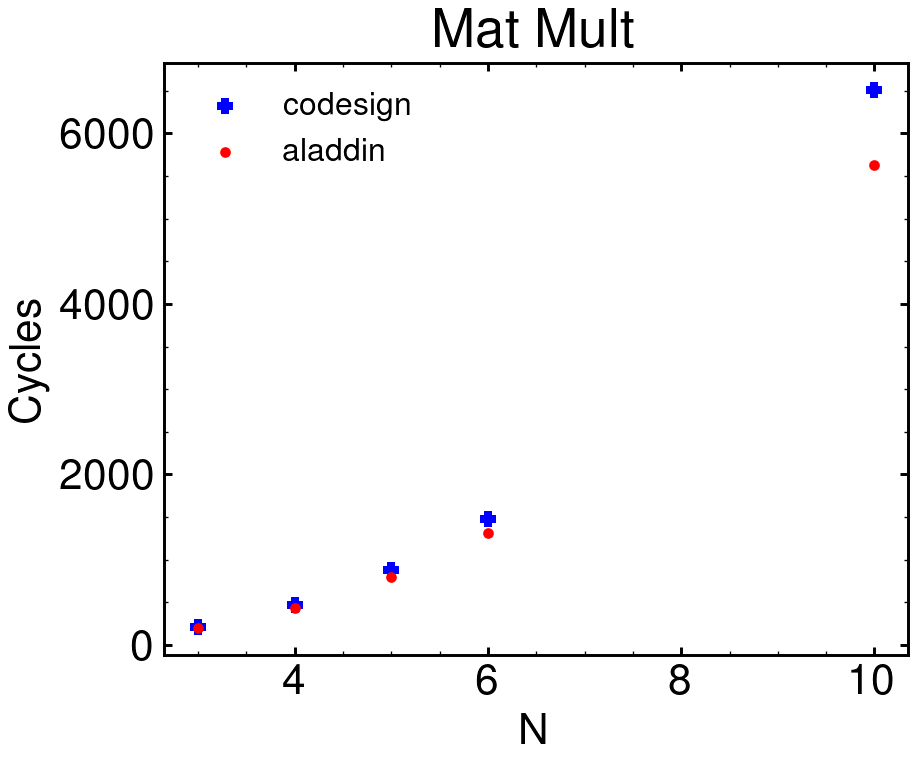

In [18]:
with mpl.rc_context({'lines.linewidth' : 2.25,
'lines.markersize' : 6,  
'figure.figsize': (5,4),
'figure.dpi': 192,
# 'axes.titlepad': 8.0,
'axes.linewidth' : 1.1,
'legend.frameon': False,
'legend.fontsize': 12,
'xtick.major.width' : 1.1,
'ytick.major.width' : 1.1,
'axes.titlesize' : 20,
'axes.labelsize' : 16,
'lines.linewidth' : 3,
'lines.markersize' : 6,
'xtick.labelsize' : 16,
'ytick.labelsize' : 16,}):
    # cycles_diff = np.asarray(unrolled_codesign['cycles']) - 9*np.asarray(mat_dim)**3 - 5*np.asarray(mat_dim)**2
    # print(cycles_diff)
    plt.scatter(mat_dim, codesign_post_fix['cycles'], marker='+', label='codesign', c='b')
    # plt.scatter(mat_dim, aladdin['cycles'], marker='.', label='aladdin - no unrolling', c='r', alpha = 0.5)
    plt.scatter(mat_dim, aladdin['cycles'], marker='.', label='aladdin', c='r')
    plt.xlabel('N')
    plt.ylabel('Cycles')
    # plt.yscale('log')
    plt.legend()
    plt.title("Mat Mult")
    plt.show()


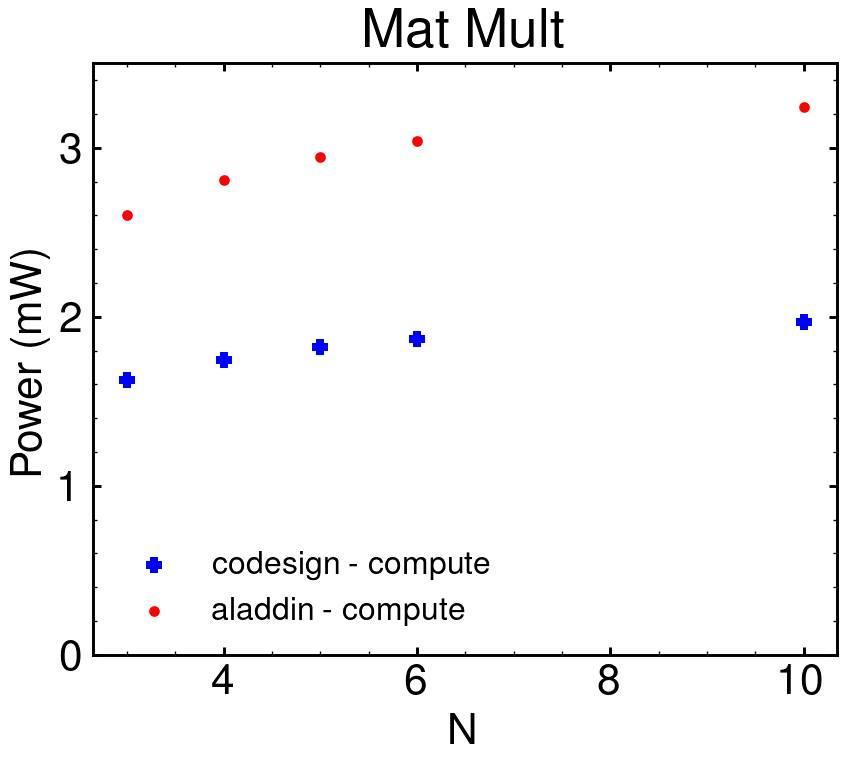

In [22]:
with mpl.rc_context({'lines.linewidth' : 2.25,
'lines.markersize' : 6,  
'figure.figsize': (5,4),
'figure.dpi': 192,
# 'axes.titlepad': 8.0,
'axes.linewidth' : 1.1,
'legend.frameon': False,
'legend.fontsize': 12,
'xtick.major.width' : 1.1,
'ytick.major.width' : 1.1,
'axes.titlesize' : 20,
'axes.labelsize' : 16,
'lines.linewidth' : 3,
'lines.markersize' : 6,
'xtick.labelsize' : 16,
'ytick.labelsize' : 16,}):
    plt.scatter(mat_dim, codesign_post_fix['compute power'], marker='+', label='codesign - compute', c='b')
    # plt.scatter(mat_dim, unrolled_codesign['mem power'], marker='^', label='codesign - mem', c='b', alpha = 0.5)

    plt.scatter(mat_dim, aladdin['compute power'], marker='.', label='aladdin - compute', c='r')
    # plt.scatter(mat_dim, unrolled_aladdin['mem power'], marker='^', label='aladdin - mem', c='r', alpha = 0.5)
    plt.xlabel('N')
    plt.ylim(0, 3.5)
    plt.ylabel('Power (mW)')
    # plt.yscale('log')
    plt.legend()
    plt.title("Mat Mult")
    plt.show()

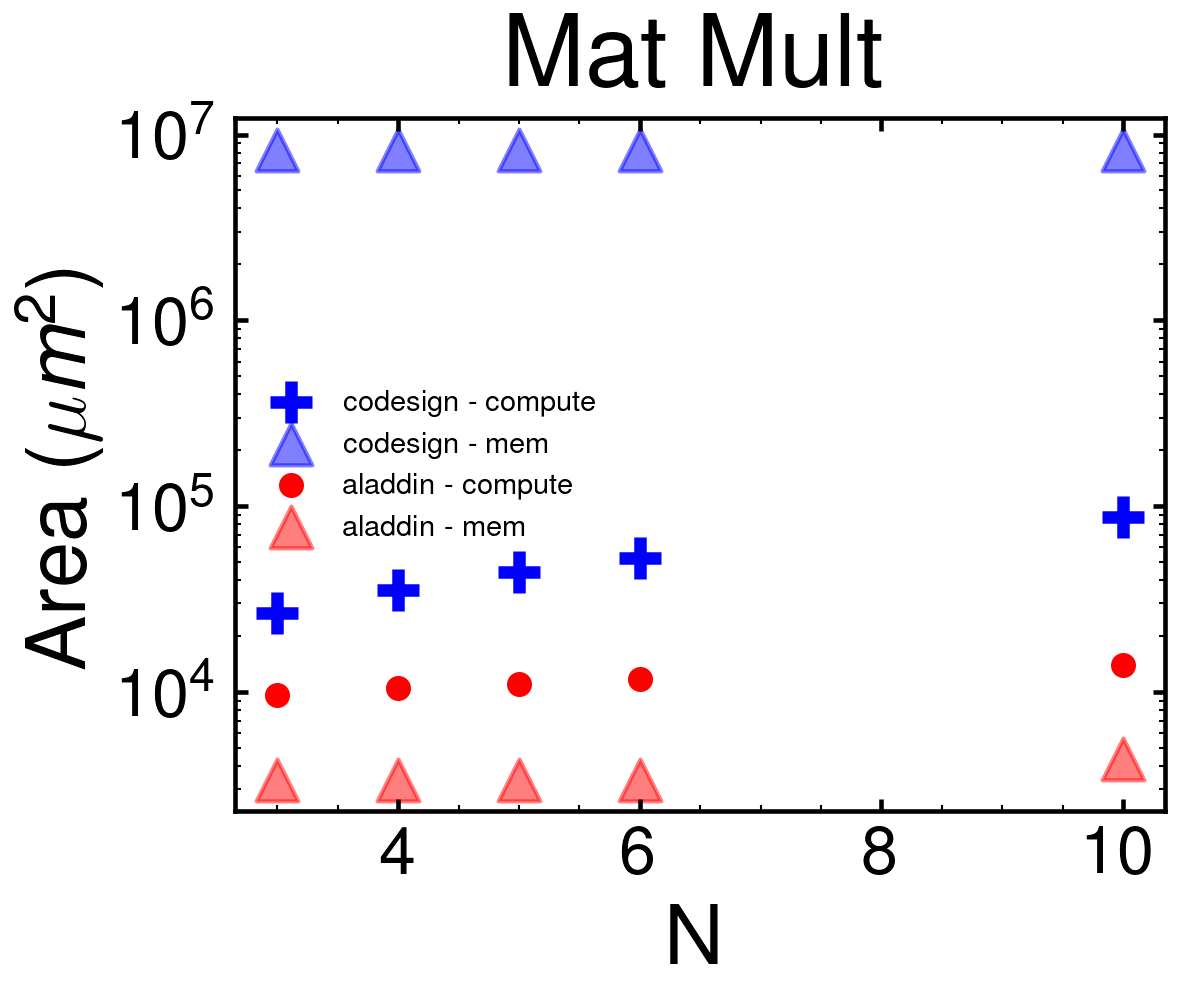

In [86]:
plt.scatter(mat_dim, unrolled_codesign['compute area'], marker='+', label='codesign - compute', c='b')
plt.scatter(mat_dim, unrolled_codesign['mem area'], marker='^', label='codesign - mem', c='b', alpha =0.5)

# total_area = np.array(unrolled_aladdin['compute area']) + np.array(unrolled_aladdin['mem area'])
plt.scatter(mat_dim, unrolled_aladdin['compute area'], marker='.', label='aladdin - compute', c='r')
plt.scatter(mat_dim, unrolled_aladdin['mem area'], marker='^', label='aladdin - mem', c='r', alpha=0.5)
plt.xlabel('N')
plt.ylabel(r'Area ($\mu m^2$)')
plt.yscale('log')
plt.legend()
plt.title("Mat Mult")
plt.show()

## Dict tests

In [2]:
tmp = {'cycles': [338, 59072, 163045, 361536, 0], 
       'avg power': [39249587.42304815 * 1e-6, 158127090.63154665 * 1e-6, 138891920.7748982*1e-6, 123833633.04556464*1e-6, 0.0]
}

for state in tmp:
    for value in state:
        print(value)

c
y
c
l
e
s
a
v
g
 
p
o
w
e
r


## NetworkX hardware representation

#### Gen from old representation (number of elems)

In [98]:
config_name = "dijkstra"
hw = HardwareModel(cfg=config_name)

FileNotFoundError: [Errno 2] No such file or directory: 'architectures/dijkstra.gml'

In [119]:
dict(hw.netlist.nodes.data())

{'Add0': {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 0},
 'Regs0': {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 0},
 'Regs1': {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 1},
 'Regs2': {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 2},
 'Mult0': {'type': 'pe', 'function': 'Mult', 'in_use': 0, 'idx': 0},
 'Eq0': {'type': 'pe', 'function': 'Eq', 'in_use': 0, 'idx': 0}}

In [120]:
for k,v in dict(hardwareModel.get_nodes_with_func(hw.netlist, "Add")).items():
    print(k)
    print(v)

Add0
{'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 0}


In [101]:
hw_netlist = nx.DiGraph() # by using directed graphs to properly indicate inputs and outputs.

In [102]:
# print(hw.hw_allocated)
allocated_hw = {
    "Add": 15,
    "Regs": 60,
    "Mult": 10,
    "Sub": 15,
    "FloorDiv": 10,
    "Gt": 0,
    "And": 0,
    "Or": 0,
    "Mod": 0,
    "LShift": 0,
    "RShift": 0,
    "BitOr": 0,
    "BitXor": 0,
    "BitAnd": 0,
    "Eq": 1,
    "NotEq": 0,
    "Lt": 0,
    "LtE": 0,
    "GtE": 0,
    "IsNot": 0,
    "USub": 0,
    "UAdd": 0,
    "Not": 0,
    "Invert": 0,
}

{'Regs': 0, 'And': 0, 'Or': 0, 'Add': 0, 'Sub': 0, 'Mult': 0, 'FloorDiv': 0, 'Mod': 0, 'LShift': 0, 'RShift': 0, 'BitOr': 0, 'BitXor': 0, 'BitAnd': 0, 'Eq': 0, 'NotEq': 0, 'Lt': 0, 'LtE': 0, 'Gt': 0, 'GtE': 0, 'IsNot': 0, 'USub': 0, 'UAdd': 0, 'Not': 0, 'Invert': 0, 'Buf': 0, 'MainMem': 0}


In [105]:
for k, v in allocated_hw.items():
    if k == "Regs":
        type = "memory"
    else:
        type = "pe"
    for i in range(v):
        hw_netlist.add_node((k + str(i)), type=type, function=k, in_use=False, idx=i)
    # print(f"k: {k}, v: {v}")
for node in hw_netlist.nodes:
    print(node)
    for node2 in hw_netlist.nodes:
        if node2 == node:
            continue
        hw_netlist.add_edge(node2, node)
        hw_netlist.add_edge(node, node2)
print(hw_netlist)
print(hw_netlist.nodes.data())
print(list(hw_netlist.edges))

Add0
Add1
Add2
Add3
Add4
Add5
Add6
Add7
Add8
Add9
Add10
Add11
Add12
Add13
Add14
Regs0
Regs1
Regs2
Regs3
Regs4
Regs5
Regs6
Regs7
Regs8
Regs9
Regs10
Regs11
Regs12
Regs13
Regs14
Regs15
Regs16
Regs17
Regs18
Regs19
Regs20
Regs21
Regs22
Regs23
Regs24
Regs25
Regs26
Regs27
Regs28
Regs29
Regs30
Regs31
Regs32
Regs33
Regs34
Regs35
Regs36
Regs37
Regs38
Regs39
Regs40
Regs41
Regs42
Regs43
Regs44
Regs45
Regs46
Regs47
Regs48
Regs49
Regs50
Regs51
Regs52
Regs53
Regs54
Regs55
Regs56
Regs57
Regs58
Regs59
Mult0
Mult1
Mult2
Mult3
Mult4
Mult5
Mult6
Mult7
Mult8
Mult9
Sub0
Sub1
Sub2
Sub3
Sub4
Sub5
Sub6
Sub7
Sub8
Sub9
Sub10
Sub11
Sub12
Sub13
Sub14
FloorDiv0
FloorDiv1
FloorDiv2
FloorDiv3
FloorDiv4
FloorDiv5
FloorDiv6
FloorDiv7
FloorDiv8
FloorDiv9
Eq0
DiGraph with 111 nodes and 8670 edges
[('Add0', {'type': 'pe', 'function': 'Add', 'in_use': False, 'idx': 0}), ('Add1', {'type': 'pe', 'function': 'Add', 'in_use': False, 'idx': 1}), ('Add2', {'type': 'pe', 'function': 'Add', 'in_use': False, 'idx': 2}), ('Add3', {'

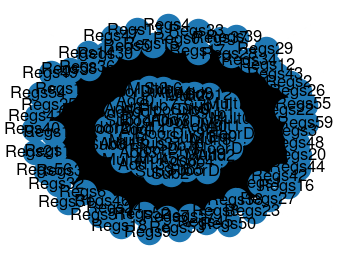

In [106]:
nx.draw(hw_netlist, with_labels=True)
plt.show()

In [107]:
tech_params = yaml.load(open("tech_params.yaml", "r"), Loader=yaml.Loader)

latency = tech_params["latency"][40]

print(hw_netlist.edges.data())
node_data = hw_netlist.nodes.data()
for edge in hw_netlist.edges.data():
    edge[2]["cost"] = latency[node_data[edge[1]]["function"]]

print(hw_netlist.edges.data())

[('Add0', 'Add1', {}), ('Add0', 'Add2', {}), ('Add0', 'Add3', {}), ('Add0', 'Add4', {}), ('Add0', 'Add5', {}), ('Add0', 'Add6', {}), ('Add0', 'Add7', {}), ('Add0', 'Add8', {}), ('Add0', 'Add9', {}), ('Add0', 'Add10', {}), ('Add0', 'Add11', {}), ('Add0', 'Add12', {}), ('Add0', 'Add13', {}), ('Add0', 'Add14', {}), ('Add0', 'Regs0', {}), ('Add0', 'Regs1', {}), ('Add0', 'Regs2', {}), ('Add0', 'Regs3', {}), ('Add0', 'Regs4', {}), ('Add0', 'Regs5', {}), ('Add0', 'Regs6', {}), ('Add0', 'Regs7', {}), ('Add0', 'Regs8', {}), ('Add0', 'Regs9', {}), ('Add0', 'Regs10', {}), ('Add0', 'Regs11', {}), ('Add0', 'Regs12', {}), ('Add0', 'Regs13', {}), ('Add0', 'Regs14', {}), ('Add0', 'Regs15', {}), ('Add0', 'Regs16', {}), ('Add0', 'Regs17', {}), ('Add0', 'Regs18', {}), ('Add0', 'Regs19', {}), ('Add0', 'Regs20', {}), ('Add0', 'Regs21', {}), ('Add0', 'Regs22', {}), ('Add0', 'Regs23', {}), ('Add0', 'Regs24', {}), ('Add0', 'Regs25', {}), ('Add0', 'Regs26', {}), ('Add0', 'Regs27', {}), ('Add0', 'Regs28', {}), 

In [ ]:
nx.dag_longest_path(hw_netlist, weight='cost')

In [109]:
nx.write_gml(hw_netlist,
 f'architectures/{config_name}.gml')

#### Some mem stuff

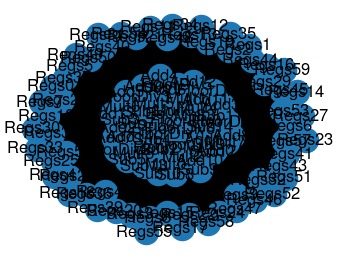

In [110]:
test = nx.read_gml(f"architectures/{config_name}.gml")
nx.draw(test, with_labels=True)
plt.show()

In [ ]:
test.add_nodes_from(
    [
            ("Mem0",
            {
                "type": "mem",
                "function": "MainMem",
                "in_use": False,
                "idx": 0,
                "size": 256,
            }),
            ("Buf0", {"type": "mem", "function": "Buf", "in_use": False, "idx": 0, "size": 1})
        
    ]
)
test.add_edges_from(
    [
        ("Buf0", "Mem0"),
        ("Mem0", "Buf0")
    ])

for node in test.nodes:
    if "Regs" in node:
        test.add_edge(node, "Buf0")
        test.add_edge("Buf0", node)



In [117]:
for node in hw_netlist.nodes:
    for node2 in hw_netlist.nodes:
        if node2 == node:
            continue
        hw_netlist.add_edge(node2, node)
        hw_netlist.add_edge(node, node2)

In [118]:
nx.write_gml(test, f"architectures/{config_name}.gml")

In [138]:
test.add_nodes_from([('Buf0', {'type': 'mem', 'function': 'Buf', 'in_use': False, 'size': 0, 'idx': 0}), ('Buf1', {'type': 'mem', 'function': 'Buf', 'in_use': False, 'size':0, 'idx': 1})])
test.add_edges_from([('Buf0', 'Regs0'), ('Regs0', 'Buf0'), ('Buf1', 'Regs1'), ('Regs1', 'Buf1'), ('Regs2', 'Buf1'), ('Buf1', 'Regs2')])

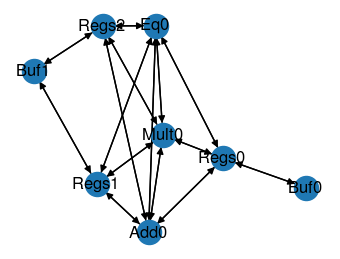

In [132]:
nx.draw(test, with_labels=True)
plt.show()

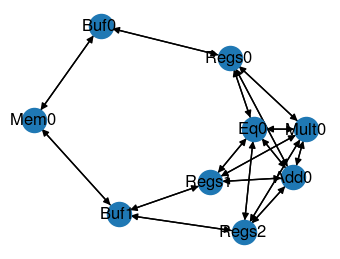

In [139]:
test.add_nodes_from(
    [(
        "Mem0", {"type": "mem", "function": "MainMem", "in_use": False, "idx": 0, 'size':256},
        # "Buf1": {"type": "mem", "function": "Buf", "in_use": False, "idx": 1},
    )]
)
test.add_edges_from(
    [
        ("Buf0", "Mem0"),
        ("Mem0", "Buf0"),
        ("Buf1", "Mem0"),
        ("Mem0", "Buf1"),
    ]
)

nx.draw(test, with_labels=True)
plt.show()

In [144]:
for node, data in  dict(filter(lambda x: x[1]['function']=='Buf', test.nodes.data())).items():
    print(node)
    print(data)
    edges = test.edges(node)
    print(f"edges: {edges}")
    for edge in edges:
        if test.nodes[edge[1]]['function'] == 'MainMem':
            print(test.nodes[edge[1]])




Buf0
{'type': 'mem', 'function': 'Buf', 'in_use': False, 'idx': 0, 'size': 0}
edges: [('Buf0', 'Regs0'), ('Buf0', 'Mem0')]
{'type': 'mem', 'function': 'MainMem', 'in_use': False, 'idx': 0, 'size': 256}
Buf1
{'type': 'mem', 'function': 'Buf', 'in_use': False, 'idx': 1, 'size': 0}
edges: [('Buf1', 'Regs1'), ('Buf1', 'Regs2'), ('Buf1', 'Mem0')]
{'type': 'mem', 'function': 'MainMem', 'in_use': False, 'idx': 0, 'size': 256}


In [ ]:
for node, data in test.nodes.data():
   if data['function'] == "Regs":
      data['size'] = 64

In [140]:
test.nodes.data()

NodeDataView({'Add0': {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 0}, 'Regs0': {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 0}, 'Regs1': {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 1}, 'Regs2': {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 2}, 'Mult0': {'type': 'pe', 'function': 'Mult', 'in_use': 0, 'idx': 0}, 'Eq0': {'type': 'pe', 'function': 'Eq', 'in_use': 0, 'idx': 0}, 'Buf0': {'type': 'mem', 'function': 'Buf', 'in_use': False, 'idx': 0, 'size': 0}, 'Buf1': {'type': 'mem', 'function': 'Buf', 'in_use': False, 'idx': 1, 'size': 0}, 'Mem0': {'type': 'mem', 'function': 'MainMem', 'in_use': False, 'idx': 0, 'size': 256}})

#### isomorphism

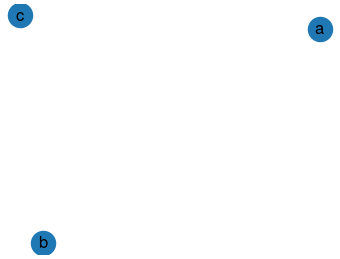

In [127]:
test_graph = nx.DiGraph()
test_graph.add_node("a")
test_graph.add_node("b")
test_graph.add_node("a")
test_graph.add_node("c")
nx.draw(test_graph, with_labels=True)
plt.show()

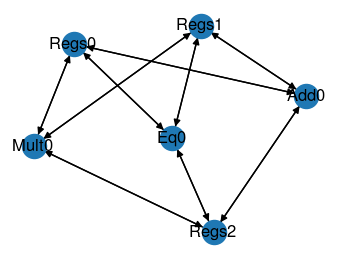

In [107]:
test_2 = test.copy()

test_2.remove_node('Regs0')
nx.draw(test, with_labels=True)
plt.show()

In [108]:
matcher = nx.isomorphism.GraphMatcher(test_graph, test_2)
matcher.subgraph_is_monomorphic()

False

In [21]:
node_data = test.nodes.data()
print(node_data)

[('Add0', {'type': 'pe', 'function': 'Add', 'in_use': 0, 'idx': 0}), ('Regs0', {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 0}), ('Regs1', {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 1}), ('Regs2', {'type': 'memory', 'function': 'Regs', 'in_use': 0, 'idx': 2}), ('Mult0', {'type': 'pe', 'function': 'Mult', 'in_use': 0, 'idx': 0}), ('Eq0', {'type': 'pe', 'function': 'Eq', 'in_use': 0, 'idx': 0})]


In [61]:
for k, v in dict(node_data).items():
    if v['function'] == 'Add':
        print(f"k: {k}, v: {v}")
        v['in_use'] = True

k: Add0, v: {'type': 'pe', 'function': 'Add', 'in_use': True}
k: Add1, v: {'type': 'pe', 'function': 'Add', 'in_use': True}
k: Add2, v: {'type': 'pe', 'function': 'Add', 'in_use': True}


In [62]:
test.nodes['Add1']['type'] = 'test'

In [64]:
for k, v in dict(node_data).items():
    v["in_use"] = False

In [63]:
for k, v in dict(node_data).items():
        print(f"k: {k}, v: {v}")

k: Add0, v: {'type': 'pe', 'function': 'Add', 'in_use': True}
k: Add1, v: {'type': 'test', 'function': 'Add', 'in_use': True}
k: Add2, v: {'type': 'pe', 'function': 'Add', 'in_use': True}
k: Regs0, v: {'type': 'memory', 'function': 'Regs', 'in_use': False}
k: Regs1, v: {'type': 'memory', 'function': 'Regs', 'in_use': False}
k: Regs2, v: {'type': 'memory', 'function': 'Regs', 'in_use': False}
k: Regs3, v: {'type': 'memory', 'function': 'Regs', 'in_use': False}
k: Regs4, v: {'type': 'memory', 'function': 'Regs', 'in_use': False}
k: Regs5, v: {'type': 'memory', 'function': 'Regs', 'in_use': False}
k: Regs6, v: {'type': 'memory', 'function': 'Regs', 'in_use': False}
k: Regs7, v: {'type': 'memory', 'function': 'Regs', 'in_use': False}
k: Regs8, v: {'type': 'memory', 'function': 'Regs', 'in_use': False}
k: Mult0, v: {'type': 'pe', 'function': 'Mult', 'in_use': False}
k: Mult1, v: {'type': 'pe', 'function': 'Mult', 'in_use': False}
k: Mult2, v: {'type': 'pe', 'function': 'Mult', 'in_use': Fal

## Results for iterative codesign

In [2]:
def parse_log_file(log_file):
    forward_edp = []
    inverse_edp = []
    with open(log_file, 'r') as f:
        lines = f.readlines()
    for line in lines:
        if "Forward EDP" in line:
            forward_edp.append(float(line.split(":")[-1].strip()))
        if "Inverse EDP" in line:
            inverse_edp.append(float(line.split(":")[-1].strip()))
    return len(forward_edp), forward_edp, inverse_edp

In [3]:
log_dir = "codesign_log_dir"
num_iters, forward_edp, inverse_edp = parse_log_file(f"{log_dir}/log.txt")

edps = [val for pair in zip(forward_edp, inverse_edp) for val in pair]

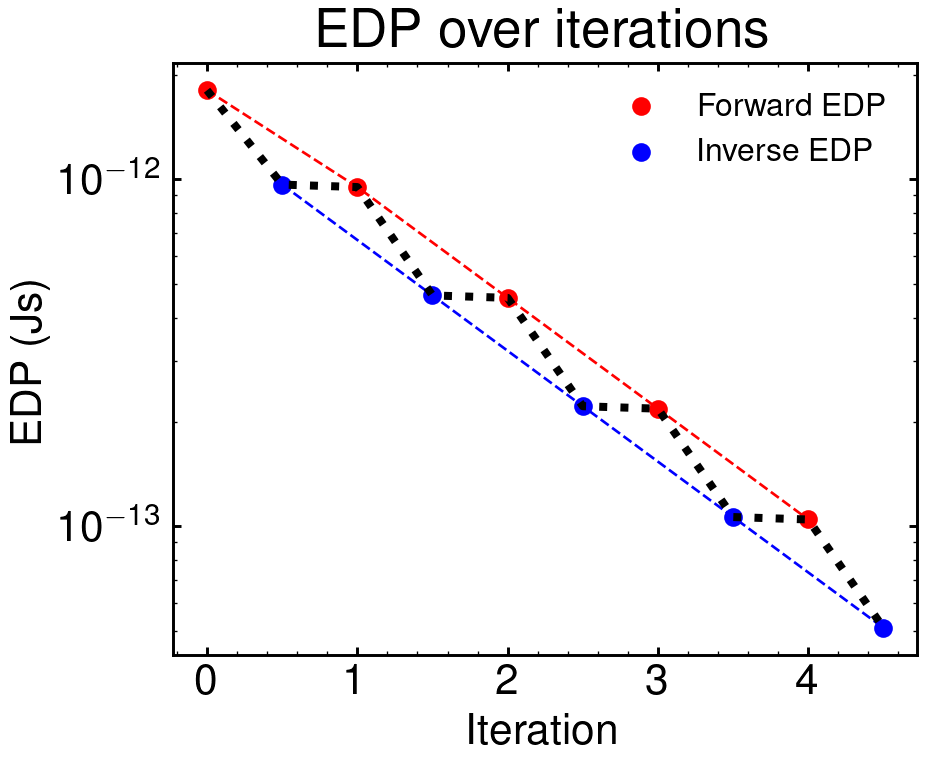

In [4]:
with mpl.rc_context({'lines.linewidth' : 2.25,
'lines.markersize' : 6,  
'figure.figsize': (5,4),
'figure.dpi': 192,
# 'axes.titlepad': 8.0,
'axes.linewidth' : 1.1,
'legend.frameon': False,
'legend.fontsize': 12,
'xtick.major.width' : 1.1,
'ytick.major.width' : 1.1,
'axes.titlesize' : 20,
'axes.labelsize' : 16,
'lines.linewidth' : 3,
'lines.markersize' : 6,
'xtick.labelsize' : 16,
'ytick.labelsize' : 16,}):
    plt.title("EDP over iterations")
    c = plt.scatter(range(num_iters), forward_edp, label="Forward EDP", c='r')
    plt.plot(range(num_iters), forward_edp, linestyle="dashed", linewidth=1, c=c.get_facecolor())
    c = plt.scatter(np.arange(0.5, num_iters+0.5), inverse_edp, label="Inverse EDP", c='b')
    plt.plot(np.arange(0.5, num_iters+0.5), inverse_edp, linestyle='dashed', linewidth=1, c= c.get_facecolor())
    plt.plot(np.arange(0, num_iters, 0.5), edps, linestyle='dotted', c= 'k')
    plt.xlabel("Iteration")
    plt.ylabel("EDP (Js)")
    plt.legend()
    plt.yscale('log')
    plt.show()

In [5]:
rcs = []
for i in range(num_iters):
    rcs.append(yaml.load(open(f"{log_dir}/rcs_{i}.yaml", "r"), Loader=yaml.Loader))

In [6]:
# remove all parameters in rcs that didn't change
keys = list(rcs[0]["Ceff"].keys())

for k in keys:
    val = rcs[0]["Ceff"][k]
    to_pop=True
    for i in range(1, num_iters):
        v = rcs[i]["Ceff"][k]
        to_pop &= (v == val)
        val = v
    if to_pop:
        for i in range(num_iters):
            rcs[i]["Ceff"].pop(k)
    
    val = rcs[0]["Reff"][k]
    to_pop = True
    for i in range(1, num_iters):
        v = rcs[i]["Reff"][k]
        to_pop &= (v == val)
        val = v
    if to_pop:
        for i in range(num_iters):
            rcs[i]["Reff"].pop(k)
print(rcs)

[{'Ceff': {'Add': 2.3390599970865665e-13, 'BitXor': 1.4922210148369764e-14, 'Regs': 7.420071756634304e-15}, 'Reff': {'Add': 2000.3375718776635, 'BitXor': 2010.4217509676698, 'Not': 2005.9573124894234, 'Regs': 134143.14748699268}, 'other': {'MemPpass': 4.655454638436581e-08, 'MemReadL': 1.999999999509408e-09, 'MemReadPact': 6.832972703487105e-11, 'MemWriteL': 1.999999999509408e-09, 'MemWritePact': 6.832972703477486e-11, 'V_dd': 1.0996798713737972, 'f': 4999999998.7287445}}, {'Ceff': {'Add': 2.3255889022174055e-13, 'BitXor': 1.4922136474365263e-14, 'Regs': 7.374933092119486e-15}, 'Reff': {'Add': 1988.849990797276, 'BitXor': 2010.4167881081548, 'Not': 1994.5751089769597, 'Regs': 133351.27252955295}, 'other': {'MemPpass': 2.2317585088416815e-08, 'MemReadL': 1.999999997739115e-09, 'MemReadPact': 6.832972697438922e-11, 'MemWriteL': 1.999999997739115e-09, 'MemWritePact': 6.832972697429303e-11, 'V_dd': 1.0985688837633527, 'f': 4999999999.498258}}, {'Ceff': {'Add': 2.312071588265023e-13, 'BitXo

In [7]:
def plot_from_rcs(k1, k2s, num_iters, rcs, title='', ylabel = '', labels=[]):
    if type(k2s) is not list:
        k2s = [k2s]
    for i in range(len(k2s)):
        k2 = k2s[i]

        val = np.asarray(list(map(lambda x: float(x[k1][k2]), rcs)))
        # name = f"{k1}_{k2}" if k1 != "other" else k2
        val = val/val[0]
        if len(labels) != 0:
            lbl = labels[i]
        else: lbl = k2
        c = plt.scatter(range(num_iters), val, label=lbl)
        plt.plot(range(num_iters), val, linestyle='dotted', c= c.get_facecolor())
    if title == '':
        title = f"{k1} over iterations"
    else:
        title += " over iterations"
    plt.title(title)

    # for i in range(num_iters):
    #     plt.scatter(rcs[i][k1], rcs[i][k2], label=f"iter {i}")
    plt.xlabel("Iteration")
    if ylabel == '':
        ylabel = f"{k1} (normalized)"
    else:
        ylabel += " (normalized)"
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

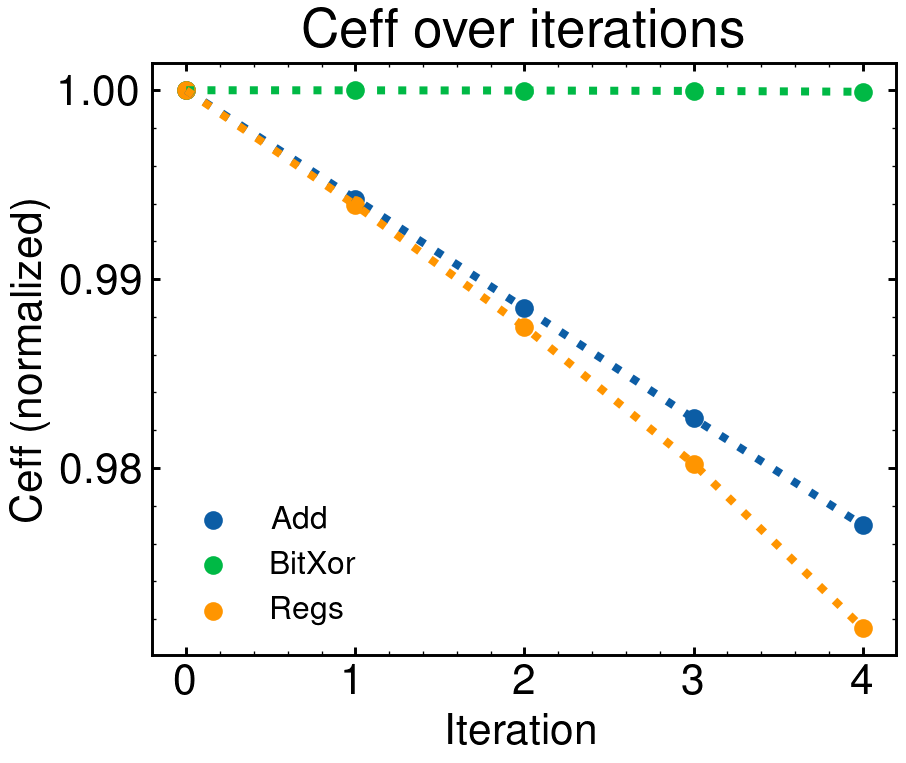

In [8]:
k1 = "Ceff"
k2s = list(rcs[0][k1].keys())
with mpl.rc_context({'lines.linewidth' : 2.25,
'lines.markersize' : 6,  
'figure.figsize': (5,4),
'figure.dpi': 192,
# 'axes.titlepad': 8.0,
'axes.linewidth' : 1.1,
'legend.frameon': False,
'legend.fontsize': 12,
'xtick.major.width' : 1.1,
'ytick.major.width' : 1.1,
'axes.titlesize' : 20,
'axes.labelsize' : 16,
'lines.linewidth' : 3,
'lines.markersize' : 6,
'xtick.labelsize' : 16,
'ytick.labelsize' : 16,}):
    plot_from_rcs(k1, k2s, num_iters, rcs)

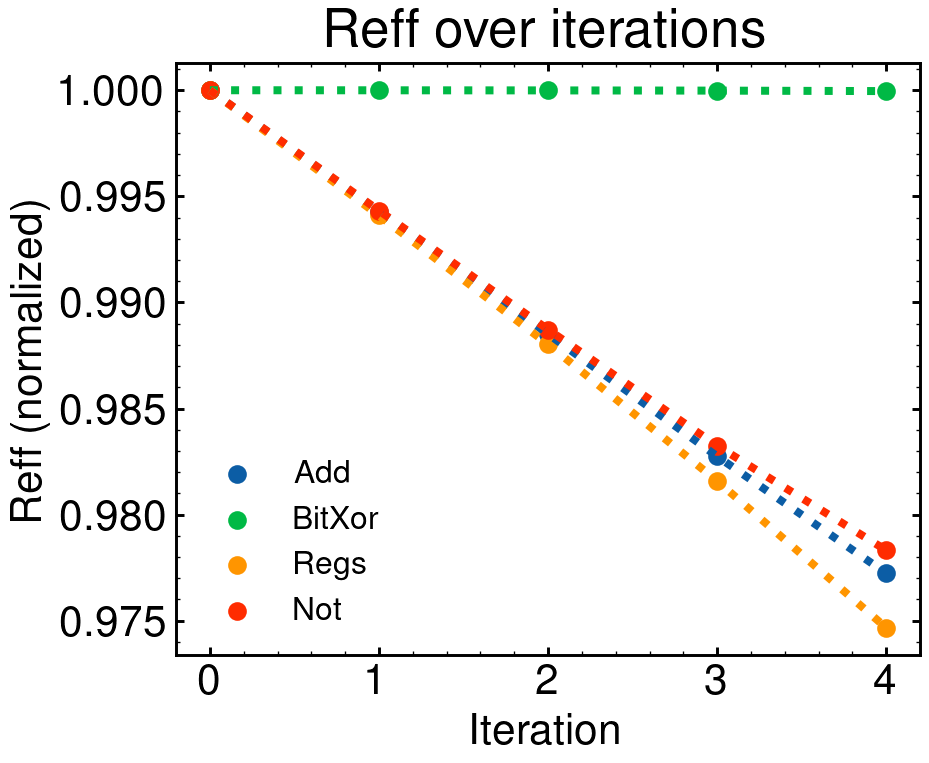

In [9]:
k1 = "Reff"
k2s = list(rcs[0][k1].keys())
tmp_idx = k2s.index("Not")
k2s.pop(tmp_idx)
k2s.append("Not")
with mpl.rc_context(
    {
        "lines.linewidth": 2.25,
        "lines.markersize": 6,
        "figure.figsize": (5, 4),
        "figure.dpi": 192,
        # 'axes.titlepad': 8.0,
        "axes.linewidth": 1.1,
        "legend.frameon": False,
        "legend.fontsize": 12,
        "xtick.major.width": 1.1,
        "ytick.major.width": 1.1,
        "axes.titlesize": 20,
        "axes.labelsize": 16,
        "lines.linewidth": 3,
        "lines.markersize": 6,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
    }
):
    plot_from_rcs(k1, k2s, num_iters, rcs)

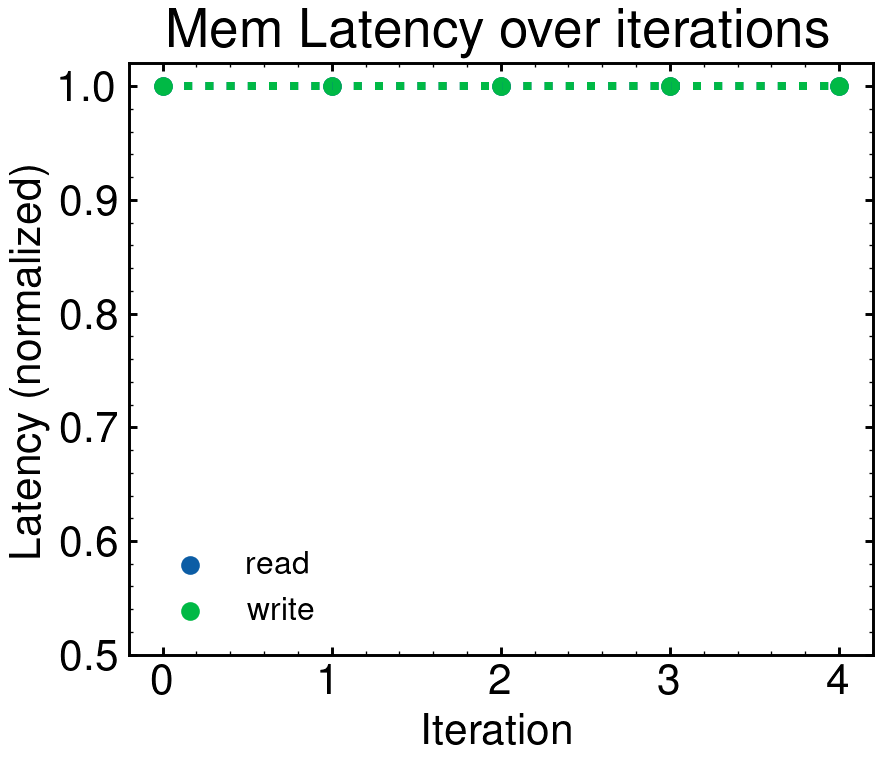

In [10]:
k1 = "other"
k2s = ["MemReadL", "MemWriteL"]
labels = ["read", "write"]
with mpl.rc_context(
    {
        "lines.linewidth": 2.25,
        "lines.markersize": 6,
        "figure.figsize": (5, 4),
        "figure.dpi": 192,
        # 'axes.titlepad': 8.0,
        "axes.linewidth": 1.1,
        "legend.frameon": False,
        "legend.fontsize": 12,
        "xtick.major.width": 1.1,
        "ytick.major.width": 1.1,
        "axes.titlesize": 20,
        "axes.labelsize": 16,
        "lines.linewidth": 3,
        "lines.markersize": 6,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
    }
):
    plt.ylim(0.5, 1.02)
    plot_from_rcs(k1, k2s, num_iters, rcs, "Mem Latency", "Latency", labels)

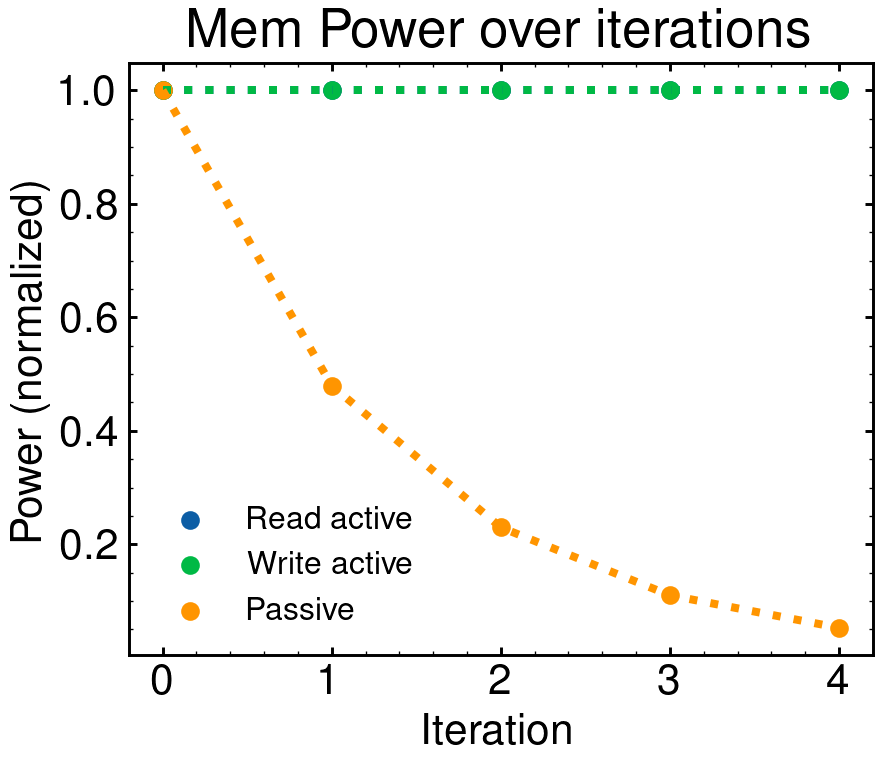

In [11]:
k1 = "other"
k2s = ["MemReadPact", "MemWritePact", "MemPpass"]
labels = ["Read active", "Write active", "Passive"]
with mpl.rc_context(
    {
        "lines.linewidth": 2.25,
        "lines.markersize": 6,
        "figure.figsize": (5, 4),
        "figure.dpi": 192,
        # 'axes.titlepad': 8.0,
        "axes.linewidth": 1.1,
        "legend.frameon": False,
        "legend.fontsize": 12,
        "xtick.major.width": 1.1,
        "ytick.major.width": 1.1,
        "axes.titlesize": 20,
        "axes.labelsize": 16,
        "lines.linewidth": 3,
        "lines.markersize": 6,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
    }
):
    plot_from_rcs(k1, k2s, num_iters, rcs, "Mem Power", "Power", labels)

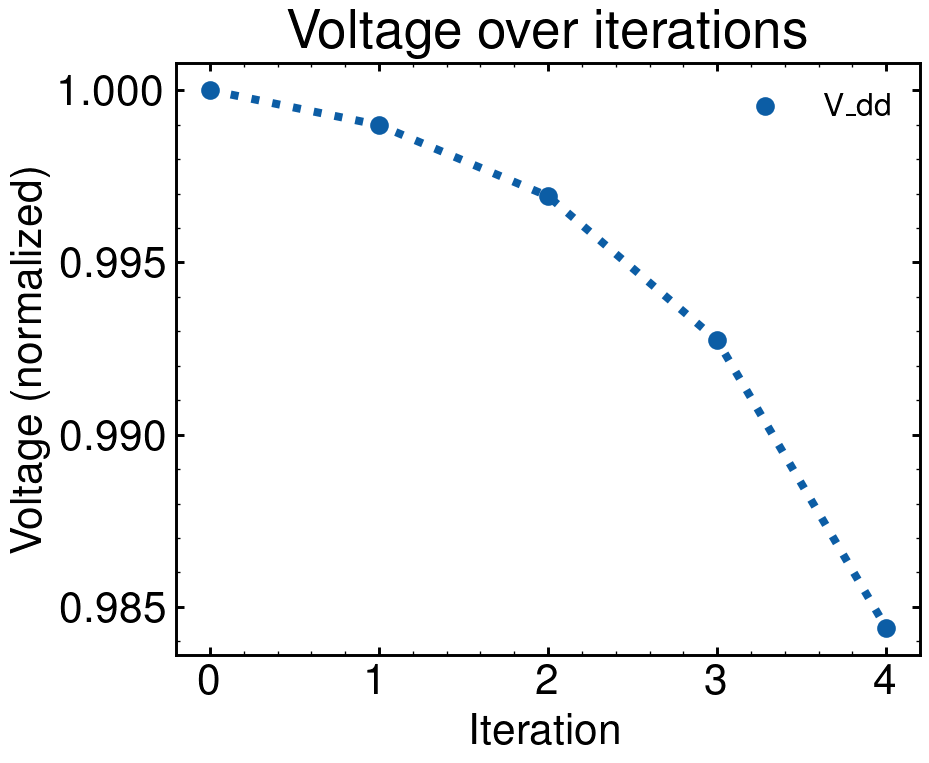

In [12]:
k1 = "other"
k2s = ["V_dd"]
# labels = ["Read active", "Write active", "Passive"]
with mpl.rc_context(
    {
        "lines.linewidth": 2.25,
        "lines.markersize": 6,
        "figure.figsize": (5, 4),
        "figure.dpi": 192,
        # 'axes.titlepad': 8.0,
        "axes.linewidth": 1.1,
        "legend.frameon": False,
        "legend.fontsize": 12,
        "xtick.major.width": 1.1,
        "ytick.major.width": 1.1,
        "axes.titlesize": 20,
        "axes.labelsize": 16,
        "lines.linewidth": 3,
        "lines.markersize": 6,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
    }
):
    plot_from_rcs(k1, k2s, num_iters, rcs, "Voltage", "Voltage")

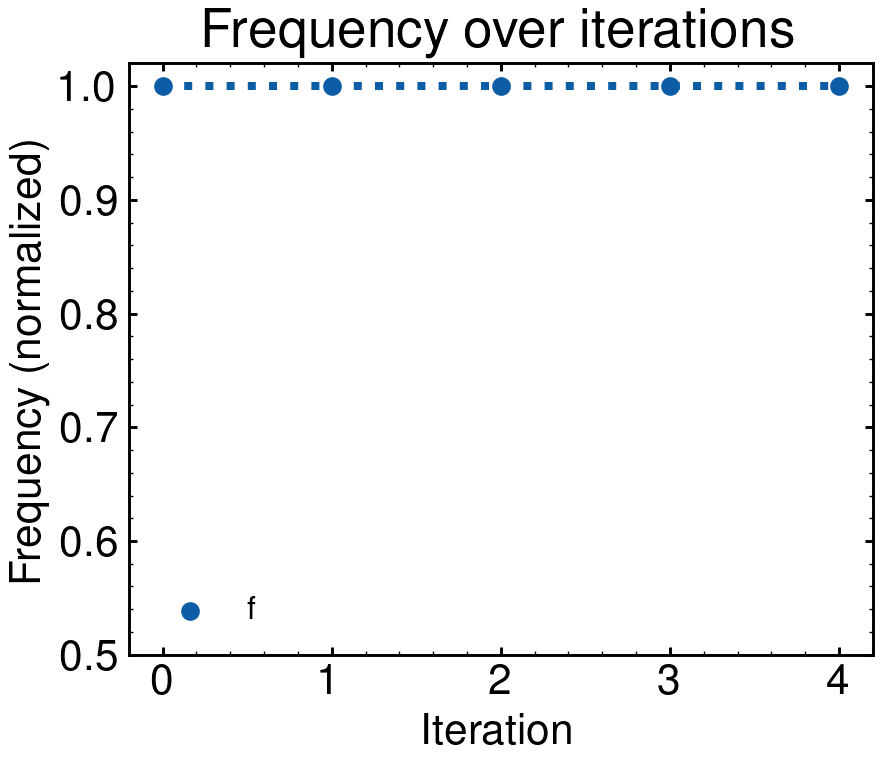

In [14]:
k1 = "other"
k2s = ["f"]
# labels = ["Read active", "Write active", "Passive"]
with mpl.rc_context(
    {
        "lines.linewidth": 2.25,
        "lines.markersize": 6,
        "figure.figsize": (5, 4),
        "figure.dpi": 192,
        # 'axes.titlepad': 8.0,
        "axes.linewidth": 1.1,
        "legend.frameon": False,
        "legend.fontsize": 12,
        "xtick.major.width": 1.1,
        "ytick.major.width": 1.1,
        "axes.titlesize": 20,
        "axes.labelsize": 16,
        "lines.linewidth": 3,
        "lines.markersize": 6,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
    }
):
    plt.ylim(0.5, 1.02)
    plot_from_rcs(k1, k2s, num_iters, rcs, "Frequency", "Frequency")